# Лабораторная работа № 2

In [1]:
import bisect
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.integrate as integrate
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate

In [2]:
def generate_sequences(generator, n):
    seq_x, seq_y = [], []
    for x, y in generator(n):
        seq_x.append(x)
        seq_y.append(y)
    return seq_x, seq_y


def plot_graphic_and_convergence(vector_x, vector_y, convergence, title, xlabel, ylabel):
    plt.plot(vector_x, vector_y)
    plt.axhline(convergence, color='red', linestyle="--")
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    
def _histogram_estimation(seq, convergence, boundaries, random_var_name, bins=20):
    xa, xb = boundaries
    if callable(convergence):
        h = (xb - xa) / 1000
        vector_x = np.arange(xa, xb + h, h)
        vector_y = [convergence(x) for x in vector_x]
        plot_convergence = lambda: plt.plot(vector_x, vector_y)
    else:
        plot_convergence = lambda: plt.hist(np.arange(xa, xb + 1), bins=bins, range=boundaries,
                                            density=True, weights=convergence, histtype='stepfilled',
                                            facecolor='none', edgecolor='red', linestyle='--')

    for n in (100, 1000, len(seq)):
        plt.hist(seq[:n], bins=bins, range=boundaries, density=True)
        plot_convergence()
        plt.grid()
        plt.title(f'Histogram for {random_var_name} N={n}, bins={bins}')
        plt.xlabel('Generate numbers interval')
        plt.ylabel('Probability density of generate numbers')
        plt.show()

    
def histogram_estimation(generator, convergences, boundaries, bins=20):
    seq_x, seq_y = generate_sequences(generator, 1000000)
    
    _histogram_estimation(seq_x, convergences[0], boundaries[0], random_var_name='X')
    _histogram_estimation(seq_y, convergences[1], boundaries[1], random_var_name='Y')


def histogram2d_estimation(generator, pxy, boundaries, print_theor_graph, bins=20):
    print_theor_graph()
    
    seq_x, seq_y = generate_sequences(generator, 1000000)
    for n in (100, 1000, len(seq_x)):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        hist, xedges, yedges = np.histogram2d(seq_x[:n], seq_y[:n], bins=bins, range=boundaries, density=True)
        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
        xpos, ypos, zpos = xpos.ravel(), ypos.ravel(), 0
        dx, dy, dz = (xb - xa) / bins, (yb - ya) / bins, hist.ravel()
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
        plt.title(f'Histogram N={n}, bins={bins}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Probability density')
        plt.show()


def _expected_values_estimation(seq, theor_exp_val, random_var_name):
    n_val, exp_val = [], []
    for n in range(100, len(seq), 10000):
        n_val.append(n)
        exp_val.append(np.mean(seq[:n]))
    
    plot_graphic_and_convergence(n_val, exp_val, convergence=theor_exp_val,
                                 title='Expected value estimation', xlabel='Count of generate numbers',
                                 ylabel=f'Expected value(M[{random_var_name}])')
    plot_graphic_and_convergence(n_val, np.fabs(np.subtract(exp_val, theor_exp_val)), convergence=0,
                                 title='Expected value estimation', xlabel='Count of generate numbers',
                                 ylabel=f'Expected value deviation(|M[{random_var_name}] - M|)')


def expected_values_estimation(generator, theor_exp_vals):
    seq_x, seq_y = generate_sequences(generator, 1000000)
    
    _expected_values_estimation(seq_x, theor_exp_vals[0], random_var_name='X')
    _expected_values_estimation(seq_y, theor_exp_vals[1], random_var_name='Y')


def _variances_estimation(seq, theor_variance, random_var_name):
    n_val, variances = [], []
    for n in range(100, len(seq), 10000):
        n_val.append(n)
        variances.append(np.var(seq[:n]))
    
    plot_graphic_and_convergence(n_val, variances, convergence=theor_variance,
                                 title='Variance estimation', xlabel='Count of generate numbers',
                                 ylabel=f'Variance(D[{random_var_name}])')
    plot_graphic_and_convergence(n_val, np.fabs(np.subtract(variances, theor_variance)), convergence=0,
                                 title='Variance estimation', xlabel='Count of generate numbers',
                                 ylabel=f'Variance deviation(|D[{random_var_name}] - D|)')


def variances_estimation(generator, theor_variances):
    seq_x, seq_y = generate_sequences(generator, 1000000)
    
    _variances_estimation(seq_x, theor_variances[0], random_var_name='X')
    _variances_estimation(seq_y, theor_variances[1], random_var_name='Y')


def correlation_estimation(generator, theor_correlation):
    seq_x, seq_y = generate_sequences(generator, 1000000)
    
    n_val, correlation = [], []
    for n in range(100, len(seq_y), 10000):
        n_val.append(n)
        correlation.append(np.corrcoef(np.vstack((seq_x[:n], seq_y[:n])))[0][1])
    
    plot_graphic_and_convergence(n_val, correlation, convergence=theor_correlation,
                                 title=f'Correlation estimation', xlabel='Count of generate numbers',
                                 ylabel=f'Correlation(R[X, Y])')

## Задание 1

In [3]:
f = lambda x, y: 2 / math.sqrt(math.pi) * math.e ** (-x - y ** 2)
xa, xb = 0, 10
ya, yb = 0, 10
fx = lambda x: math.e ** (-x)
fy = lambda y: 2 / math.sqrt(math.pi) * math.e ** (-(y ** 2))
zmax = f(0, 0)
mx, my = 1, 1 / math.sqrt(math.pi)
dx, dy = 1, 1 / 2 - 1 / math.pi
kxy = 0

In [4]:
def _neyman_generator():
    while True:
        x = xa + random.random() * (xb - xa)
        y = ya + random.random() * (yb - ya)
        z = random.random() * zmax

        if f(x, y) >= z:
            return x, y


def neyman_generator(n):
    while n:
        yield _neyman_generator()
        n -= 1

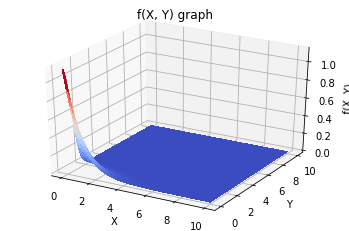

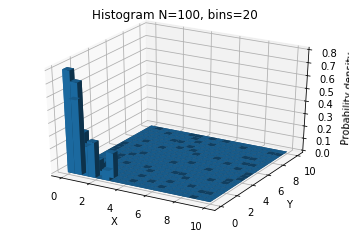

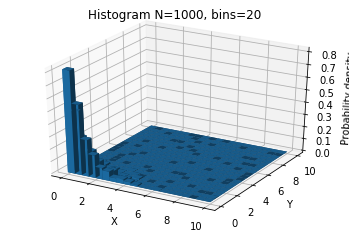

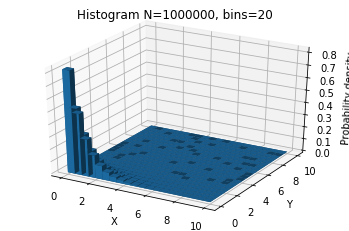

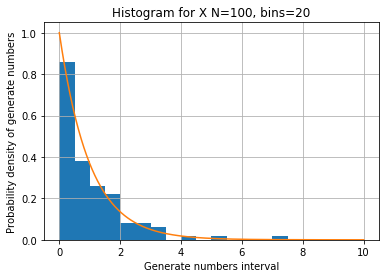

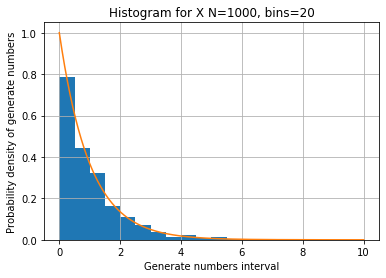

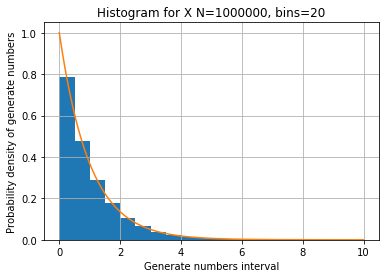

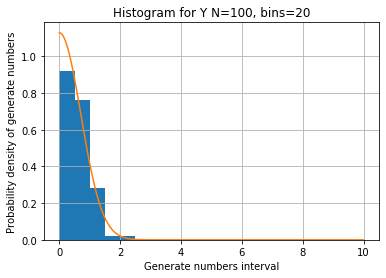

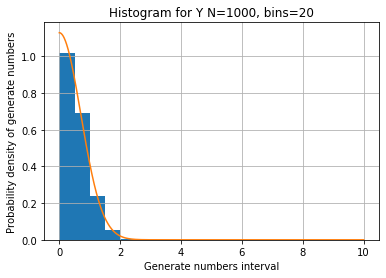

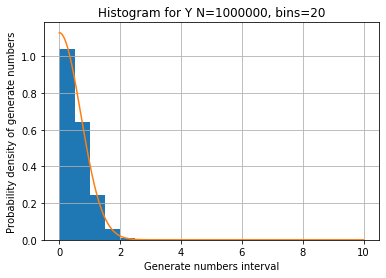

In [5]:
def print_theor_graph(bins=20):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    vector_x = np.arange(xa, xb, (xb - xa) / 1000)
    vector_y = np.arange(ya, yb, (yb - ya) / 1000)
    vector_x, vector_y = np.meshgrid(vector_x, vector_y)
    vector_z = f(vector_x.ravel(), vector_y.ravel()).reshape(vector_x.shape)
    surf = ax.plot_surface(vector_x, vector_y, vector_z, cmap=cm.coolwarm, antialiased=False)
    plt.title('f(X, Y) graph')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    plt.show()


histogram2d_estimation(neyman_generator, f, ((xa, xb), (ya, yb)), print_theor_graph)
histogram_estimation(neyman_generator, (fx, fy), ((xa, xb), (ya, yb)))

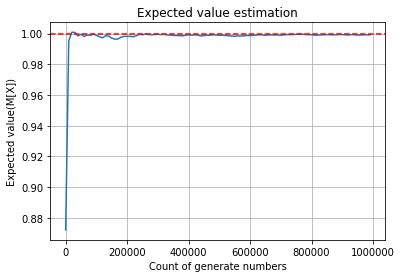

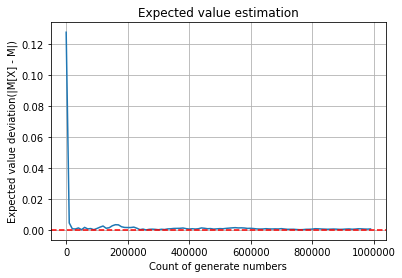

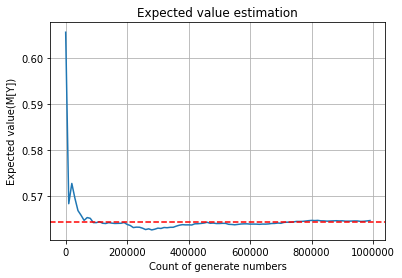

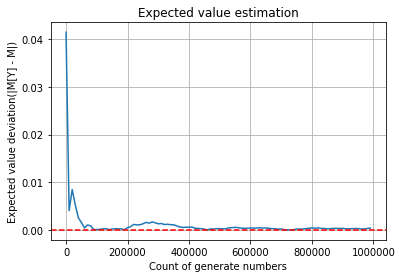

In [6]:
expected_values_estimation(neyman_generator, (mx, my))

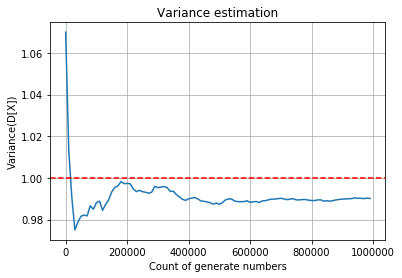

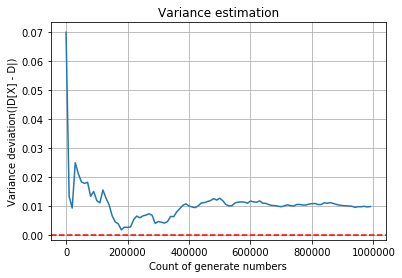

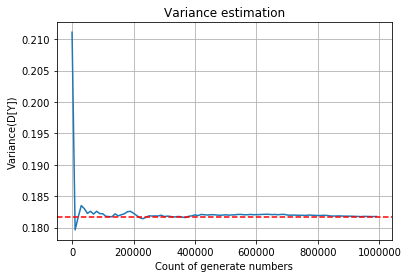

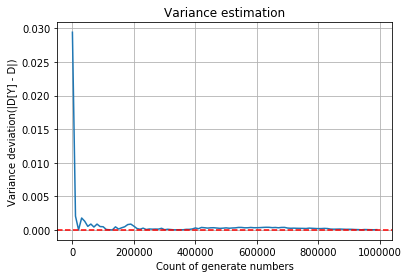

In [7]:
variances_estimation(neyman_generator, (dx, dy))

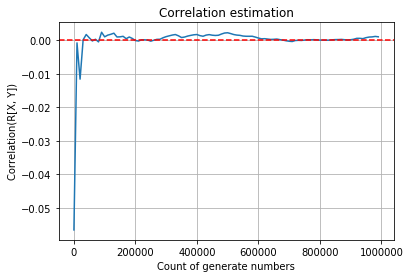

In [8]:
correlation_estimation(neyman_generator, 0)

## Задание 2

In [9]:
def generate_probability_array(n):
    arr = [(1, n)]
    is_construct = False
    while not is_construct:
        is_construct = True
        new_arr = []
        for pair in arr:
            if pair[1] == 1:
                new_arr.append(pair)
            else:
                is_construct = False
                half_p, half_n = random.random() * pair[0], pair[1] // 2
                new_arr.append((half_p, half_n))
                new_arr.append((pair[0] - half_p, pair[1] - half_n))
        
        arr = new_arr
    
    return [pair[0] for pair in arr]


def construct_distribution_function(parr):
    arr = [0] * len(parr)
    for i, p in enumerate(parr[:-1]):
        arr[i + 1] = arr[i] + p
    return arr


def discrete_expected_value(parr):
    return sum([i * p for i, p in enumerate(parr)])


def discrete_variance(parr):
    exp_val = discrete_expected_value(parr)
    return sum([(i - exp_val) ** 2 * p for i, p in enumerate(parr)])


def print_distribution_matrix(pxy):
    data = [['X/Y'] + list(np.arange(len(pxy[0])))]
    for x, p in enumerate(pxy):
        data.append([x] + p)
    print(tabulate(data, tablefmt="grid"))


px = generate_probability_array(100)
xa, xb = 0, len(px) - 1
py = generate_probability_array(40)
ya, yb = 0, len(py) - 1
pxy = [[i * j for i in py] for j in px]
fx = construct_distribution_function(px)
fy = construct_distribution_function(py)
mx, my = discrete_expected_value(px), discrete_expected_value(py)
dx, dy = discrete_variance(px), discrete_variance(py)
kxy = 0

# print_distribution_matrix(pxy)

In [10]:
def discrete_generator(n):
    while n:
        xp = random.random()
        yp = random.random()
        yield bisect.bisect_left(fx, xp) - 1, bisect.bisect_left(fy, yp) - 1
        
        n -= 1

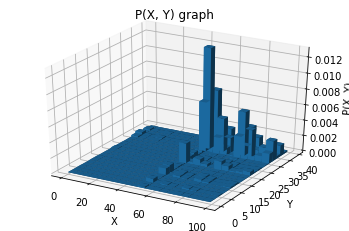

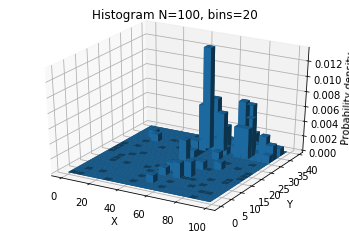

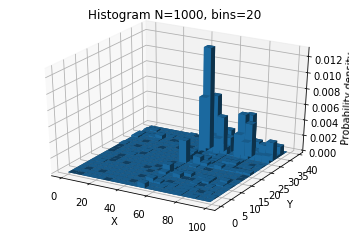

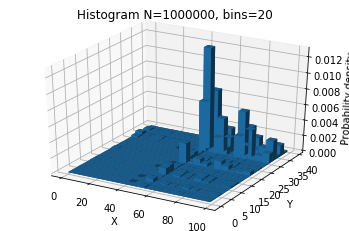

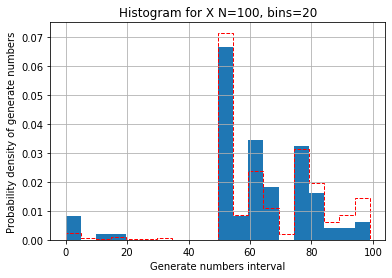

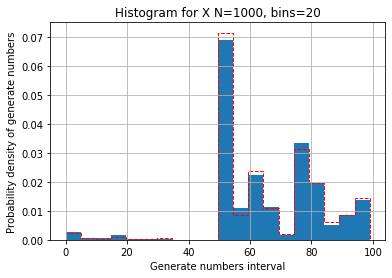

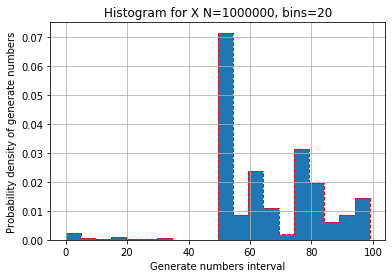

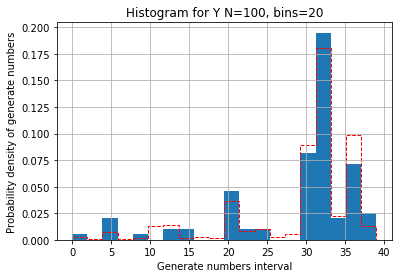

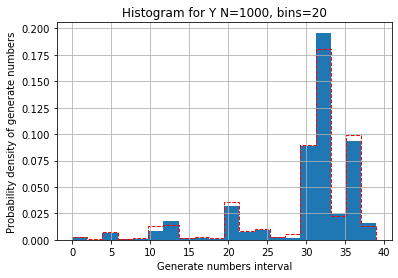

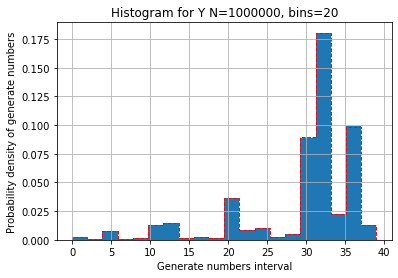

In [11]:
def print_theor_graph(bins=20):
    vector_x, vector_y = np.meshgrid(np.arange(len(pxy)), np.arange(len(pxy[0])), indexing='ij')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    hist, xedges, yedges = np.histogram2d(vector_x.ravel(), vector_y.ravel(), bins=bins, range=((xa, xb), (ya, yb)),
                                          density=True, weights=np.array(pxy).ravel())
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
    xpos, ypos, zpos = xpos.ravel(), ypos.ravel(), 0
    dx, dy, dz = (xb - xa) / bins, (yb - ya) / bins, hist.ravel()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
    plt.title('P(X, Y) graph')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('P(X, Y)')
    plt.show()


histogram2d_estimation(discrete_generator, pxy, ((xa, xb), (ya, yb)), print_theor_graph)
histogram_estimation(discrete_generator, (px, py), ((xa, xb), (ya, yb)))

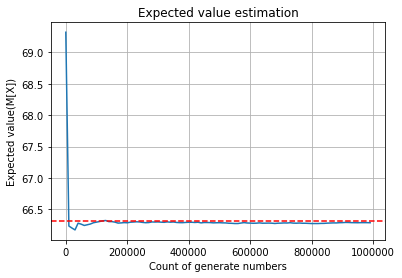

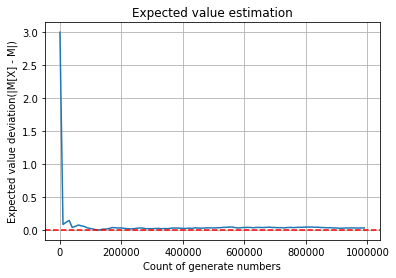

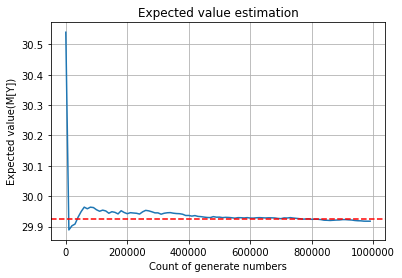

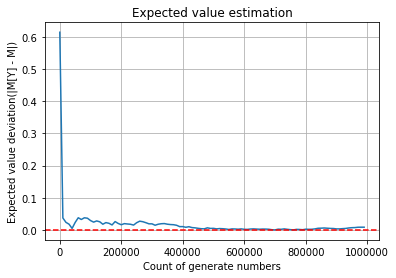

In [12]:
expected_values_estimation(discrete_generator, (mx, my))

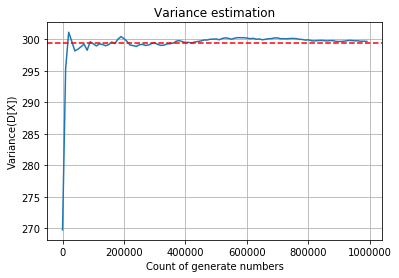

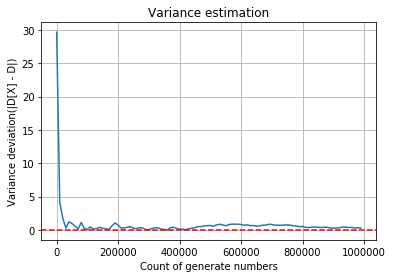

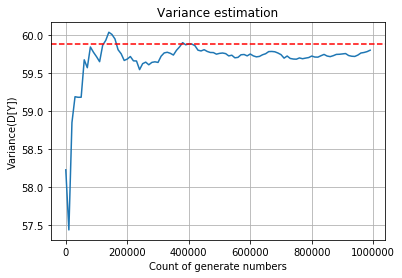

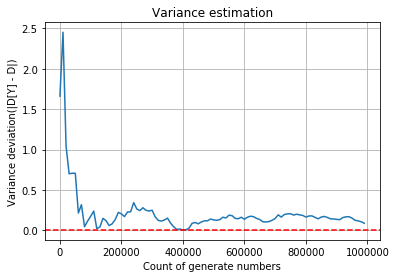

In [13]:
variances_estimation(discrete_generator, (dx, dy))

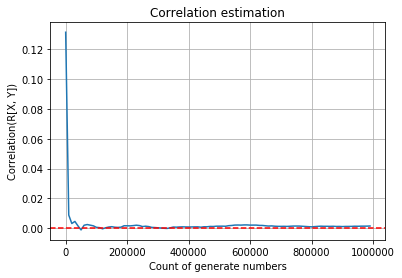

In [14]:
correlation_estimation(discrete_generator, kxy)